In [1]:
import random as rd
import numpy as np
import matplotlib.pyplot as plot



# MODELLO BASE

### Considero avviata la cascata dal momento in cui due partecipanti compiono la stessa scelta esco dal while e passo alla simulazione successiva. 
Innanzitutto vengono definiti quattro parametri: priorblue e priorred sono le probabilità a priori di avere l'urna con maggioranza blu o rossa rispettivamente, mentre blue e red rappresentano la corrispondenza tra segnale e colore della pallina.

Successivamente viene definita la probabilità q che dato lo stato "good" (cioè l'urna a maggioranza blu) si abbia un segnale "high" (cioè la pallina blu) e dato lo stato "bad" (cioè l'urna a maggioranza rossa) si abbia un segnale "low" (cioè la pallina blu).

Il codice è un'implementazione di un modello di "social learning", il cui obiettivo è studiare il modo in cui gli individui possono influenzarsi reciprocamente nella formazione delle proprie opinioni e decisioni.

Il modello utilizza un esempio concreto, ovvero una situazione in cui un gruppo di persone deve indovinare il contenuto di un'urna che contiene un certo numero di palline rosse e blu. Ogni partecipante effettua una estrazione dall'urna e decide se il contenuto è maggiormente rosso o blu. Gli altri partecipanti possono essere influenzati dalla scelta dei loro compagni e, in particolare, potrebbero cambiare idea se vedono che la maggioranza dei partecipanti ha scelto in modo diverso da loro.

Il modello si articola in diversi passaggi. Innanzitutto, viene definito lo "stato dell'universo", ovvero se la maggioranza delle palline nell'urna è rossa o blu. Vengono poi estratti casualmente un certo numero di partecipanti, ciascuno dei quali effettua un'estrazione dall'urna. In base al risultato dell'estrazione, ogni partecipante decide se il contenuto dell'urna è maggiormente rosso o blu.

Il primo passaggio consiste nel creare un vettore che raccoglie la giusta proporzione di palline rosse e blu in base allo stato dell'universo. Se la maggioranza delle palline è rossa, il vettore avrà due palline rosse e una blu, mentre se la maggioranza è blu, il vettore avrà due palline blu e una rossa.

La scelta di ogni partecipante viene influenzata da una probabilità di errore e dal parametro "q", che viene utilizzato per calcolare le probabilità "a priori" che l'urna contenga una maggioranza di palline rosse o blu, utilizzando il teorema di Bayes.

In [2]:
priorblue = 0.5
priorred = 0.5
blue = 0
red = 1
#q è la prob che dato lo stato good si abbia un high signal e dato lo stato bad si abbia un low signal (prob che la pallina sia rossa se l'urna è a maggioranza rossa e blu se è a maggioranza blu)
q = 2/3
    
#definisce in modo casuale lo stato dell'universo (maggioranza rossa, maggioranza blu)
def universe():
    state = rd.randint(0,1)
    return state

#definisce il numero di partecipanti all'esperimento
def partecipants():
    num = rd.randint(3,100)
    return num

#riempie un vettore con la corretta proporzione di palline a seconda dello stato dell'universo
def vector_world(state):
    alternative = [0,1]
    if state == 1:
        world = [1,1,0]
    else:
        world = [0,0,1]
    return world

#effettua l'estrazione della pallina dall'urna
def extraction(world):
    signal = rd.choice(world)
    return signal

#calcola la probabilità che data una serie di segnali, l'urna sia a maggioranza rossa o blu
def bayes(p, a , b , q):
    denom = ( p * (q**a) * ((1-q)**b) + (1-p) * ((1-q)**a) * (q**b) )
    if denom == 0:
        denom = np.nextafter(0, 1)
    post = ( p * (q**a) * ((1-q)**b) )/ denom
    return post

#effettua la scelta in base alle posterior
def make_decision(postblue, postred, signal):
    if postblue > postred:
        choice = 0
    elif postblue < postred:
        choice = 1 
    else:
        choice = signal
    return choice

#verifica se due giocatori compiono consecutivamente la stessa scelta dando quindi origine ad una cascata\n",
def controller(vector,i):
    if len(vector) == 1:   
        return None
    else:
        if vector[i] == vector[i - 1]:
            return False
        return True


#dinamica per un partecipante
def singlepartecipant(a, b, q, state, world, correct_signal, count_coherent, count_incoherent):
    
    signal = extraction(world)
    if signal == state:
        correct_signal += 1
    if signal == 1:
        a += 1
    else:
        b += 1
    
    postred = bayes(priorred, a, b, q)
    postblue = 1 - postred
   
    choice = make_decision(postblue, postred, signal)
    if signal == choice:
        count_coherent += 1
        return a, b, choice, count_coherent, count_incoherent, correct_signal, postblue, postred, signal

    else:
        if signal == 1: 
            a -= 1
            b += 1
        else:
            a += 1
            b -= 1        
        count_incoherent += 1     
        return a, b, choice, count_coherent, count_incoherent, correct_signal, postblue, postred, signal

#vettore che raccoglie il numero di volte in cui la scelta = segnale ad ogni esperimento
vector_coherent = []

#vettore che raccoglie il numero di volte in cui la scelta è diversa dal segnale ad ogni esperimento
vector_incoherent = []

#vettore che raccoglie il numero di volte che la cascata porta alla soluzione corretta
correct_guesses = []

#vettore che raccoglie il numero di partecipanti per ogni simulazione
vector_participants = []

#vettore che raccoglie in ogni simulazione il numero di passi necessari a dare avvio ad una cascata
counter = []

#vettore che raccoglie in ogni simulazione il numero di ribelli necessari a interrompere la cascata
vect_rebel = []
    
#vettore che raccoglie l'indice di ogni simulazione
vector_sim = []

#contatore per numero di volte in cui la cascata porta ad un risultato corretto
num_correct_cascade = 0

num_sim = 1000

correct_cascade_rate = 0
correct_guesses_rate = []

#faccio num_sim simulazioni
for j in range(0,num_sim):

    #estraggo casualmente il numero di partecipanti dell'esperimento
    numpart = partecipants()

    #vettore con i numeri da 0 a numpart
    vector_part = []

    #vettore che raccoglie i segnali
    signal_vect = []

    #vettore che raccoglie il numero di partecipanti ad ogni simulazione
    vector_participants.append(numpart)

    #creo lo stato dell'universo
    state = universe()

    #creo il vettore che contiene la giusta proporzione di palline
    world = vector_world(state)

    #calcolo la probabilità di estrarre una pallina rossa condizionata allo stato dell'universo
    q = 2/3
    
    #inizializzo contatore segnale rosso
    a = 0

    #inizializzo contatore segnale blu
    b = 0

    #vettore delle scelte
    choice = []

    #numero di volte in cui il segnale e la scelta corrispondono
    count_coherent = 0

    #numero di volte in cui il segnale e la scelta non corrispondono
    count_incoherent = 0

    #parametro di controllo per la cascata
    control = True
    i = 1
    
    #conta il numero di cascate per ogni simulazione
    counter_cascade_single_simulation = 0
    #conta il numero di passi necessari per innescare una cascata, ad ogni simulazione si resetta. Si utilizza poi per fare una media dividendo per il numero di volte che si è verificata in quella simulazione una cascata. Poi si aggiunge al vettore che tiene conto di tutte le simulazioni il risultato.
    counter_steps_single_simulation = 0
    #conta il numero di cascate corrette per ogni simulazione
    num_correct_cascade = 0
    
    diff = 0 
    num_rebel = 0
    correct_signal = 0
    
    #eseguo la funzione su ogni partecipante all'esperimento
    while i <= numpart:
        a, b, single_choice, count_coherent, count_incoherent, correct_signal, postblue, postred, signal = singlepartecipant(a, b, q, state, world, correct_signal, count_coherent, count_incoherent)
        vector_part.append(i)
        choice.append(single_choice)
        signal_vect.append(signal)
        #verifico se due partecipanti consecutivi abbiano fatto la stessa scelta
        if controller(choice,i-1) == False and control == True:
            control = False
            #aggiungo al vettore il numero di passi che ci sono voluti per avviare la cascata
            counter.append(i)
            counter_cascade_single_simulation += 1 
            #verifico se la cascata è corretta
            if ((choice[i-1] == 0 and state == 0) or (choice[i-1] == 1 and state == 1)):
                num_correct_cascade += 1
            break
        i += 1 
        
    if counter_cascade_single_simulation == 0:
        counter_cascade_single_simulation = 1
        
    correct_cascade_rate += num_correct_cascade/counter_cascade_single_simulation
                  
    #vettore che contiene il rate di correttezza della cascata dopo (j+1) simulazioni
    correct_guesses.append(correct_cascade_rate/(j+1))
    #vettore che contiene il numero della simulazione
    vector_sim.append(j+1)
    
    vector_coherent.append(count_coherent)
    vector_incoherent.append(count_incoherent)



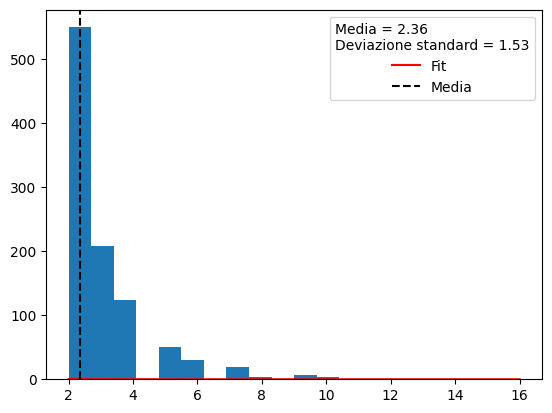

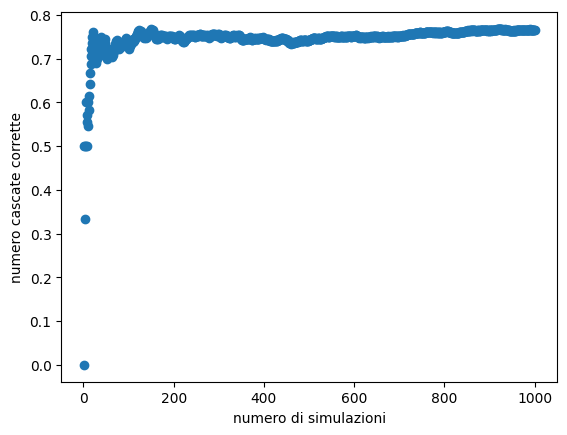

In [3]:
import numpy as np
import matplotlib.pyplot as plot
from scipy.stats import poisson
from scipy.optimize import curve_fit




# Creo un istogramma dei dati
counts, bins, _ = plot.hist(counter, bins=20)

# Definisco la funzione di distribuzione di probabilità che si vuole usare per il fit (in questo caso una distribuzione di Poisson)
def poissonian(k, mu):
    return poisson.pmf(k, mu)

# Eseguo il fit dei dati con la funzione di distribuzione di Poisson
popt, pcov = curve_fit(poissonian, bins[:-1], counts)

# Creo una curva usando i parametri del fit
x_curve = np.linspace(bins[0], bins[-1], 100)
y_curve = poissonian(x_curve, *popt)

# Disegno l'istogramma dei dati e la curva di fit
plot.plot(x_curve, y_curve, 'r-', label='Fit')

# Aggiungi la media alla figura
mu = popt[0]
sigma = np.sqrt(mu)
plot.axvline(mu, color='k', linestyle='--', label='Media')

plot.legend(title=f"Media = {mu:.2f}\nDeviazione standard = {sigma:.2f}")


# Mostro il grafico
plot.show()

   
#faccio grafico della percentuale di cascate corrette
plot.scatter(vector_sim, correct_guesses)
plot.xlabel('numero di simulazioni')
plot.ylabel('numero cascate corrette')
plot.show()






# MODELLO CON RIBELLI

### Introduco un partecipante randomico che sceglie in opposizione alla maggioranza. Studio come varia la cascata aumentando la probabilità che un partecipante sia un ribelle ( e quindi il numero dei ribelli ). Il modello tiene quindi conto della presenza di "ribelli", ovvero partecipanti che non seguono la maggioranza ma scelgono l'opzione opposta. I ribelli possono interrompere una cascata di informazione, ma solo se sono in grado di convincere un numero sufficiente di partecipanti a seguirli.




In [4]:
priorblue = 0.5
priorred = 0.5
blue = 0
red = 1
#q è la prob che dato lo stato good si abbia un high signal e dato lo stato bad si abbia un low signal (prob che la pallina sia rossa se l'urna è a maggioranza rossa e blu se è a maggioranza blu)
q = 2/3
    
#definisce in modo casuale lo stato dell'universo (maggioranza rossa, maggioranza blu)
def universe():
    state = rd.randint(0,1)
    return state

#definisce il numero di partecipanti all'esperimento
def partecipants():
    num = rd.randint(3,100)
    return num

#riempie un vettore con la corretta proporzione di palline a seconda dello stato dell'universo
def vector_world(state):
    alternative = [0,1]
    if state == 1:
        world = [1,1,0]
    else:
        world = [0,0,1]
    return world

#effettua l'estrazione della pallina dall'urna
def extraction(world):
    signal = rd.choice(world)
    return signal

#calcola la probabilità che data una serie di segnali, l'urna sia a maggioranza rossa o blu
def bayes(p, a , b , q):
    denom = ( p * (q**a) * ((1-q)**b) + (1-p) * ((1-q)**a) * (q**b) )
    if denom == 0:
        denom = np.nextafter(0, 1)
    post = ( p * (q**a) * ((1-q)**b) )/ denom
    return post

#effettua la scelta in base alle posterior
def make_decision(postblue, postred, signal):
    if postblue > postred:
        choice = 0
    elif postblue < postred:
        choice = 1 
    else:
        choice = signal
    return choice

#verifica se due giocatori compiono consecutivamente la stessa scelta dando quindi origine ad una cascata\n",
def controller(vector,i):
    if len(vector) == 1:   
        return None
    else:
        if vector[i] == vector[i - 1]:
            return False
        return True


#dinamica per un partecipante
def singlepartecipant(a, b, q, state, world, correct_signal, count_coherent, count_incoherent):
    
    signal = extraction(world)
    if signal == state:
        correct_signal += 1
    if signal == 1:
        a += 1
    else:
        b += 1
    
    postred = bayes(priorred, a, b, q)
    postblue = 1 - postred
   
    choice = make_decision(postblue, postred, signal)
    if signal == choice:
        count_coherent += 1
        return a, b, choice, count_coherent, count_incoherent, correct_signal, postblue, postred, signal

    else:
        if signal == 1: 
            a -= 1
            b += 1
        else:
            a += 1
            b -= 1        
        count_incoherent += 1     
        return a, b, choice, count_coherent, count_incoherent, correct_signal, postblue, postred, signal

#il ribelle sceglie la scelta minoritaria
def rebel(a, b, var, state, correct_signal, count_coherent, count_incoherent, q):
    
    choice = var
    signal = extraction(world)

    if choice == state:
        correct_signal += 1

    if choice == 1:
        a += 1
    else:
        b += 1
        
    if choice == signal:
        count_coherent += 1
    else:
        count_incoherent += 1
    
    postred = bayes(priorred, a, b, q)
    postblue = 1 - postred

    return a, b, choice, signal, count_coherent, count_incoherent,correct_signal, postblue, postred

def prob_rebel():
    return rd.random()

def checkpost(post0,post1):
    if post0 > post1:
        return 0
    elif post0 < post1: 
        return 1
    else:
        return 3

        
    

In [5]:
    
#vettore che raccoglie il numero di volte in cui la scelta = segnale ad ogni esperimento
vector_coherent = []

#vettore che raccoglie il numero di volte in cui la scelta è diversa dal segnale ad ogni esperimento
vector_incoherent = []

#vettore che raccoglie il numero di volte che la cascata porta alla soluzione corretta
correct_guesses = []

#vettore che raccoglie il numero di partecipanti per ogni simulazione
vector_participants = []

#vettore che raccoglie in ogni simulazione il numero di ribelli necessari a interrompere la cascata
vect_rebel = []
    
#vettore che raccoglie l'indice di ogni simulazione
vector_sim = []

#vettore che raccoglie ad ogni simulazione la probabilità che un partecipante sia un ribelle
vector_prob_rebel = []

num_sim = 3

correct_cascade_rate = []
#vettore che raccoglie in ogni simulazione il numero di passi necessari a dare avvio ad una cascata
counter = []
counter_cascade = []
#vettore che raccoglie in ogni simulazione il numero di ribelli necessari a interrompere la cascata
vect_rebel = []
vector_rebellion = []
counter_simulation = []

    
for h in range(0,2):

    #estraggo casualmente il numero di partecipanti dell'esperimento
    numpart = partecipants()
    
    #vettore che raccoglie il numero di partecipanti ad ogni simulazione
    vector_participants.append(numpart)
    
    rebel_prob = prob_rebel()
    
    vector_prob_rebel.append(rebel_prob)
    
    counter_rebellion = 0
    
    #contatore per numero di volte in cui la cascata porta ad un risultato corretto
    num_correct_cascade = 0
    
    #conta il numero di cascate
    counter_cascade_simulation = 0
        
    num_rebel = 0
    
    correct_signal = 0
    counter_rebellion = 0
        
    #conta il numero di cascate corrette per ogni simulazione
    num_correct_cascade = 0
   
    
    #faccio num_sim simulazioni
    for j in range(0,num_sim):
        
        #vettore con i numeri da 0 a numpart
        vector_part = []

        #vettore che raccoglie i segnali
        signal_vect = []

        #creo lo stato dell'universo
        state = universe()

        #creo il vettore che contiene la giusta proporzione di palline
        world = vector_world(state)

        #calcolo la probabilità di estrarre una pallina rossa condizionata allo stato dell'universo
        q = 2/3
        
        #inizializzo contatore segnale rosso
        a = 0

        #inizializzo contatore segnale blu
        b = 0

        #vettore delle scelte
        choice = []

        #numero di volte in cui il segnale e la scelta corrispondono
        count_coherent = 0

        #numero di volte in cui il segnale e la scelta non corrispondono
        count_incoherent = 0

        #parametro di controllo per la cascata
        control = True
        
        i = 1
        diff = 0 
       
        
        
        #eseguo la funzione su ogni partecipante all'esperimento
        while i <= numpart:
            
            #se non si è verificata la cascata
            if control == True:
                a, b, single_choice, count_coherent, count_incoherent, correct_signal, postblue, postred, signal = singlepartecipant(a, b, q, state, world, correct_signal, count_coherent, count_incoherent)
                vector_part.append(i)
                choice.append(single_choice)
                signal_vect.append(signal)
                
            
            #verifico se due partecipanti consecutivi abbiano fatto la stessa scelta
                if controller(choice,i-1) == False:
                    control = False
                    signal_cascade = single_choice
                    #aggiungo al vettore il numero di passi che ci sono voluti per avviare la cascata
                    counter_simulation.append(i)
                    counter_cascade_simulation += 1 
                    #verifico se la cascata è corretta
                    if ((choice[i-1] == 0 and state == 0) or (choice[i-1] == 1 and state == 1)):
                        num_correct_cascade += 1
                        
                    max_post = checkpost(postblue,postred)
        
            #se si è verificata la cascata
            else:
                
                rebel_random = prob_rebel()
                if rebel_random <= rebel_prob:
                    num_rebel += 1
                    a, b, single_choice, signal, count_coherent, count_incoherent, correct_signal, postblue, postred = rebel(a,b,1-signal_cascade,state,correct_signal,count_coherent,count_incoherent,q)
                    vector_part.append(i)
                    choice.append(single_choice)
                    signal_vect.append(signal)
                    max_post_rebel = checkpost(postblue,postred)
                    if max_post != max_post_rebel:
                        counter_rebellion += 1
                    
                else:
                    a, b, single_choice, count_coherent, count_incoherent, correct_signal, postblue, postred, signal = singlepartecipant(a, b, q, state, world, correct_signal, count_coherent, count_incoherent)
                    vector_part.append(i)
                    choice.append(single_choice)
                    signal_vect.append(signal)
                    
                i += 1
    if counter_cascade_simulation == 0:
        counter_cascade_simulation = 1
        num_correct_cascade = 0
            
    correct_cascade_rate.append(num_correct_cascade/counter_cascade_simulation)
    #vettore lungo come il numero di cicli su h, che contiene le medie fatte su numsim simulazioni del numero di partecipanti prima che inizi la cascata
    counter.append(np.mean(counter_simulation))
    #vettore lungo come il numero di cicli su h, che contiene il numero delle cascate in totale nelle numsim simulazioni
    counter_cascade.append(counter_cascade_simulation)
    #vettore lungo come il numero di cicli su h, che contiene il numero di ribelli dopo numsim simulazioni 
    vect_rebel.append(num_rebel/(numpart*num_sim))
    #vettore lungo come il numero di cicli su h, che contiene il numero di ribellioni dopo numsim simulazioni 
    vector_rebellion.append(counter_rebellion)   

    vector_coherent.append(count_coherent)
    vector_incoherent.append(count_incoherent)

Faccio una verifica della linearità tra la probabilità che un giocatore sia un ribelle e la densità di ribelli nelle simulazioni.

In [ ]:
plot.scatter(vector_prob_rebel,vect_rebel)
plot.xlabel('probabilità che un partecipante sia un ribelle')
plot.ylabel('numero di ribelli nella simulazione')
plot.show()

plot.scatter(vector_prob_rebel,vector_rebellion)
plot.xlabel('probabilità che un partecipante sia un ribelle')
plot.ylabel('numero di ribellioni')
plot.show()

In [ ]:

from scipy.stats import poisson
from scipy.optimize import curve_fit


# Creo un istogramma dei dati
counts, bins, _ = plot.hist(counter, bins=20)

# Definisco la funzione di distribuzione di probabilità che si vuole usare per il fit (in questo caso una distribuzione di Poisson)
def poissonian(k, mu):
    return poisson.pmf(k, mu)

# Eseguo il fit dei dati con la funzione di distribuzione di Poisson
popt, pcov = curve_fit(poissonian, bins[:-1], counts)

# Creo una curva usando i parametri del fit
x_curve = np.linspace(bins[0], bins[-1], 100)
y_curve = poissonian(x_curve, *popt)

# Disegno l'istogramma dei dati e la curva di fit
plot.plot(x_curve, y_curve, 'r-', label='Fit')

# Aggiungi la media alla figura
mu = popt[0]
sigma = np.sqrt(mu)
plot.axvline(mu, color='k', linestyle='--', label='Media')

plot.legend(title=f"Media = {mu:.2f}\nDeviazione standard = {sigma:.2f}")


# Mostro il grafico
plot.show()

   
#faccio grafico della percentuale di cascate corrette
plot.scatter(vector_sim, correct_guesses)
plot.xlabel('numero di simulazioni')
plot.ylabel('numero cascate corrette')
plot.show()


plot.hist(vect_rebel, bins=10, edgecolor='black')
plot.title("Istogramma del numero di ribelli necessari ad interrompere una cascata")
plot.xlabel("numero di ribelli")
plot.ylabel("Occorrenze")
plot.show()


# MODELLO CON PARTECIPANTI CHE SEGUONO IL PROPRIO SEGNALE

In [ ]:
priorblue = 0.5
priorred = 0.5
blue = 0
red = 1
#q è la prob che dato lo stato good si abbia un high signal e dato lo stato bad si abbia un low signal (prob che la pallina sia rossa se l'urna è a maggioranza rossa e blu se è a maggioranza blu)
q = 2/3
    
#definisce in modo casuale lo stato dell'universo (maggioranza rossa, maggioranza blu)
def universe():
    state = rd.randint(0,1)
    return state

#definisce il numero di partecipanti all'esperimento
def partecipants():
    num = rd.randint(3,100)
    return num

#riempie un vettore con la corretta proporzione di palline a seconda dello stato dell'universo
def vector_world(state):
    alternative = [0,1]
    if state == 1:
        world = [1,1,0]
    else:
        world = [0,0,1]
    return world

#effettua l'estrazione della pallina dall'urna
def extraction(world):
    signal = rd.choice(world)
    return signal

#calcola la probabilità che data una serie di segnali, l'urna sia a maggioranza rossa o blu
def bayes(p, a , b , q):
    denom = ( p * (q**a) * ((1-q)**b) + (1-p) * ((1-q)**a) * (q**b) )
    if denom == 0:
        denom = np.nextafter(0, 1)
    post = ( p * (q**a) * ((1-q)**b) )/ denom
    return post

#effettua la scelta in base alle posterior
def make_decision(postblue, postred, signal):
    if postblue > postred:
        choice = 0
    elif postblue < postred:
        choice = 1 
    else:
        choice = signal
    return choice

#verifica se due giocatori compiono consecutivamente la stessa scelta dando quindi origine ad una cascata\n",
def controller(vector,i):
    if len(vector) == 1:   
        return None
    else:
        if vector[i] == vector[i - 1]:
            return False
        return True


#dinamica per un partecipante
def singlepartecipant(a, b, q, state, world, correct_signal, count_coherent, count_incoherent):
    
    signal = extraction(world)
    if signal == state:
        correct_signal += 1
    if signal == 1:
        a += 1
    else:
        b += 1
    
    postred = bayes(priorred, a, b, q)
    postblue = 1 - postred
   
    choice = make_decision(postblue, postred, signal)
    if signal == choice:
        count_coherent += 1
        return a, b, choice, count_coherent, count_incoherent, correct_signal, postblue, postred, signal

    else:
        if signal == 1: 
            a -= 1
            b += 1
        else:
            a += 1
            b -= 1        
        count_incoherent += 1     
        return a, b, choice, count_coherent, count_incoherent, correct_signal, postblue, postred, signal

#il ribelle sceglie secondo il proprio segnale
def rebel(a, b, state, correct_signal, count_coherent, count_incoherent, q):
    
    choice = extraction(world)

    if choice == state:
        correct_signal += 1

    if choice == 1:
        a += 1
    else:
        b += 1
        
    count_coherent += 1
   
    postred = bayes(priorred, a, b, q)
    postblue = 1 - postred

    return a, b, choice, count_coherent, count_incoherent,correct_signal, postblue, postred

def prob_rebel():
    return rd.random()

def checkpost(post0,post1):
    if post0 > post1:
        return 0
    elif post0 < post1: 
        return 1
    else:
        return 3

In [ ]:
    
#vettore che raccoglie il numero di volte in cui la scelta = segnale ad ogni esperimento
vector_coherent = []

#vettore che raccoglie il numero di volte in cui la scelta è diversa dal segnale ad ogni esperimento
vector_incoherent = []

#vettore che raccoglie il numero di volte che la cascata porta alla soluzione corretta
correct_guesses = []

#vettore che raccoglie il numero di partecipanti per ogni simulazione
vector_participants = []

#vettore che raccoglie in ogni simulazione il numero di passi necessari a dare avvio ad una cascata
counter = []

#vettore che raccoglie in ogni simulazione il numero di ribelli necessari a interrompere la cascata
vect_rebel = []
    
#vettore che raccoglie l'indice di ogni simulazione
vector_sim = []

#vettore che raccoglie ad ogni simulazione la probabilità che un partecipante sia un ribelle
vector_prob_rebel = []

num_sim = 5


correct_guesses_rate = []
vector_cascade = []
vector_rebellion = []
    
for h in range(0,3):

    #estraggo casualmente il numero di partecipanti dell'esperimento
    numpart = partecipants()
    
    #vettore che raccoglie il numero di partecipanti ad ogni simulazione
    vector_participants.append(numpart)
    
    rebel_prob = prob_rebel()
    
    vector_prob_rebel.append(rebel_prob)
    
    counter_rebellion = 0
    
    correct_cascade_rate = 0
    
    #contatore per numero di volte in cui la cascata porta ad un risultato corretto
    num_correct_cascade = 0
    
    #conta il numero di cascate
    counter_cascade_simulation = 0
        
    num_rebel = 0
    
    correct_signal = 0
    counter_rebellion = 0
        
    #conta il numero di cascate corrette per ogni simulazione
    num_correct_cascade = 0
    
    counter_simulation = []
    
    counter_cascade = []
    
    correct_cascade_rate = []
    
    vector_correct_cascade_rate = []
    
    #faccio num_sim simulazioni
    for j in range(0,num_sim):
        
        #vettore con i numeri da 0 a numpart
        vector_part = []

        #vettore che raccoglie i segnali
        signal_vect = []

        #creo lo stato dell'universo
        state = universe()

        #creo il vettore che contiene la giusta proporzione di palline
        world = vector_world(state)

        #calcolo la probabilità di estrarre una pallina rossa condizionata allo stato dell'universo
        q = 2/3
        
        #inizializzo contatore segnale rosso
        a = 0

        #inizializzo contatore segnale blu
        b = 0

        #vettore delle scelte
        choice = []

        #numero di volte in cui il segnale e la scelta corrispondono
        count_coherent = 0

        #numero di volte in cui il segnale e la scelta non corrispondono
        count_incoherent = 0

        #parametro di controllo per la cascata
        control = True
        
        i = 1
        diff = 0 
       
        
        
        #eseguo la funzione su ogni partecipante all'esperimento
        while i <= numpart:
            
            #se non si è verificata la cascata
            if control == True:
                a, b, single_choice, count_coherent, count_incoherent, correct_signal, postblue, postred, signal = singlepartecipant(a, b, q, state, world, correct_signal, count_coherent, count_incoherent)
                vector_part.append(i)
                choice.append(single_choice)
                signal_vect.append(signal)
                
            
            #verifico se due partecipanti consecutivi abbiano fatto la stessa scelta
                if controller(choice,i-1) == False:
                    control = False
                    signal_cascade = single_choice
                    #aggiungo al vettore il numero di passi che ci sono voluti per avviare la cascata
                    counter_simulation.append(i)
                    counter_cascade_simulation += 1 
                    #verifico se la cascata è corretta
                    if ((choice[i-1] == 0 and state == 0) or (choice[i-1] == 1 and state == 1)):
                        num_correct_cascade += 1
                        
                    max_post = checkpost(postblue,postred)
        
            #se si è verificata la cascata
            else:
                
                rebel_random = prob_rebel()
                if rebel_random <= rebel_prob:
                    num_rebel += 1
                    a, b, signal, count_coherent, count_incoherent, correct_signal, postblue, postred = rebel(a,b,state,correct_signal,count_coherent,count_incoherent,q)
                    vector_part.append(i)
                    choice.append(signal)
                    signal_vect.append(signal)
                    max_post_rebel = checkpost(postblue,postred)
                    if max_post != max_post_rebel:
                        counter_rebellion += 1
                    
                else:
                    a, b, single_choice, count_coherent, count_incoherent, correct_signal, postblue, postred, signal = singlepartecipant(a, b, q, state, world, correct_signal, count_coherent, count_incoherent)
                    vector_part.append(i)
                    choice.append(single_choice)
                    signal_vect.append(signal)
                    
                i += 1
    if counter_cascade_simulation == 0:
        counter_cascade_simulation = 1
        num_correct_cascade = 0
    correct_cascade_rate.append(num_correct_cascade/counter_cascade_simulation)
    
    #vettore lungo come il numero di cicli su h, che contiene le medie fatte su numsim simulazioni del numero di partecipanti prima che inizi la cascata
    counter.append(np.mean(counter_simulation))
    #vettore lungo come il numero di cicli su h, che contiene il numero delle cascate in totale nelle numsim simulazioni
    counter_cascade.append(counter_cascade_simulation)
    #vettore lungo come il numero di cicli su h, che contiene il numero di ribelli dopo numsim simulazioni 
    vect_rebel.append(num_rebel) 
    #vettore lungo come il numero di cicli su h, che contiene il numero di ribellioni dopo numsim simulazioni 
    vector_rebellion.append(counter_rebellion)   

    vector_coherent.append(count_coherent)
    vector_incoherent.append(count_incoherent)

In [ ]:

from scipy.stats import poisson
from scipy.optimize import curve_fit


# Creo un istogramma dei dati
counts, bins, _ = plot.hist(counter, bins=20)

# Definisco la funzione di distribuzione di probabilità che si vuole usare per il fit (in questo caso una distribuzione di Poisson)
def poissonian(k, mu):
    return poisson.pmf(k, mu)

# Eseguo il fit dei dati con la funzione di distribuzione di Poisson
popt, pcov = curve_fit(poissonian, bins[:-1], counts)

# Creo una curva usando i parametri del fit
x_curve = np.linspace(bins[0], bins[-1], 100)
y_curve = poissonian(x_curve, *popt)

# Disegno l'istogramma dei dati e la curva di fit
plot.plot(x_curve, y_curve, 'r-', label='Fit')

# Aggiungi la media alla figura
mu = popt[0]
sigma = np.sqrt(mu)
plot.axvline(mu, color='k', linestyle='--', label='Media')

plot.legend(title=f"Media = {mu:.2f}\nDeviazione standard = {sigma:.2f}")


# Mostro il grafico
plot.show()

   
#faccio grafico della percentuale di cascate corrette
plot.scatter(vector_sim, correct_guesses)
plot.xlabel('numero di simulazioni')
plot.ylabel('numero cascate corrette')
plot.show()


plot.hist(vect_rebel, bins=10, edgecolor='black')
plot.title("Istogramma del numero di ribelli necessari ad interrompere una cascata")
plot.xlabel("numero di ribelli")
plot.ylabel("Occorrenze")
plot.show()